# Extraction des pluies journalières de plusieurs pixels du dataset SM2RAIN (grille mondiale de 12.5 km)
https://zenodo.org/record/3635932#.XoWskagzZhG   

- placez les fichiers annuels SM2RAIN consécutifs dans le même dossier (1 fichier par année de  2007 à 2019)
- renommez si besoin les fichiers quand le numéro de version est variable selon les années, ce qui n'est pas traité dans le code
- copiez-collez le nom du dossier de travail dans la variable "path" du code
- saisissez l'année de début et de fin dans les variables year_start et year_end
- saisissez les coordonnées géographiques des pixels à extraire dans le fichier lonlat_.txt 
- Lancez le script et patientez jusqu'à la fin du traitement qui prend une dizaine de secondes ou plus selon le nombre de pixels

NB: le code original (python 2.7 uniquement !) est modifié et complété (LDU) pour...
- fonctionner avec python 3.x
- traiter plusieurs pixels au lieu d'un seul (mais marche également pour 1 seul point)
- modifier les années de début et fin, et permettre un simple copier-coller du nom de dossier au format Windows (sinon anti slash est interprété comme un caracètre de contrôle)
- calculer les cumuls mensuels
- extraires les données journalières et mensuelles dans un fichier texte
- (pour le fun) allonger l'axe des temps des graphiques et améliorer leur esthétique au moyen de la librarie "seaborn" (et leur ajouter un menu d'interactivité, mais ne marche pas)
- (en cours, non fonctionnel), générer un fichier texte contenant TOUS les pixels mondiaux, de façon à pouvoir l'ouvrir dans Qgis dans une couche raster et ainsi sélectionner facilement les pixels inclus dans un bassin versant

## Lecture et visualisation des données (code original python 2.7 adapté)

[[ 5.42333 43.52833]
 [ 6.3861  43.3831 ]
 [ 5.78333 43.96167]
 [ 5.41333 43.88   ]]


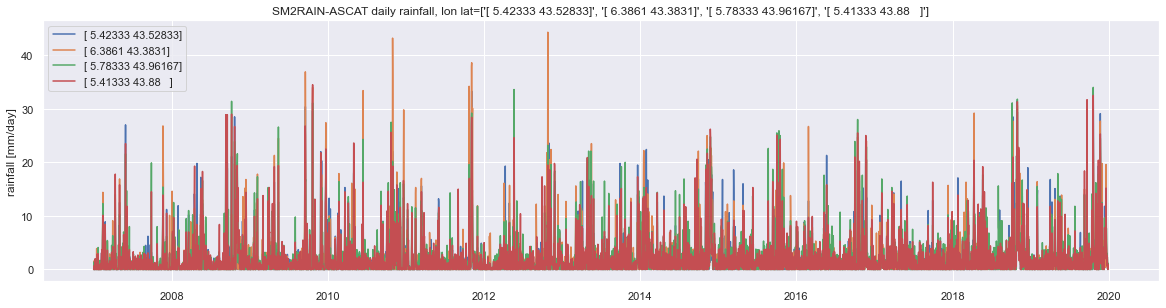

In [2]:
"""
Created on Jul 2020
Original code from https://zenodo.org/record/3635932#.XoWskagzZhG
Improved for N points extraction by @author: Loïc Duffar
"""
%matplotlib notebook
%matplotlib inline
import os
import netCDF4
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # En principe nécessaire pour utiliser matplotlib au travers seaborn (sinon inutile pour matplotlib seul)
sns.set()
matplotlib.rcParams["figure.figsize"] =[20., 4.8]
path = r"X:\1-COMMUN\DIS\Documentation\Hydrologie\Documentation externe\Climat Monde\Pluies SM2RAIN\12.5km 2007-2019".replace("\\","/")
nc_f = os.path.join(path, 'SM2RAIN_ASCAT_0125_2007_v1.1.nc')
nc_fid = netCDF4.Dataset(nc_f, 'r')
year_start= 2007
year_end= 2019
# -------------------Index of the stations you want to extract
stat= np.loadtxt(os.path.join(path, 'lonlat_.txt'))
print(stat)
lat_ = nc_fid.variables['Latitude'][:]
lon_ = nc_fid.variables['Longitude'][:]
tree = spatial.KDTree(list(zip(lon_.ravel(),lat_.ravel())))
[d,ID]= tree.query(stat)
# -------------------Extraction of SM2RAIN-ASCAT rainfall from 2007 to 2019
datahub = []
if isinstance(ID, np.int64):
    ID=[ID]
for i in ID:
    datahub.append([])
for ii in np.arange(year_start, year_end+1):
    nc_f = os.path.join(path,'SM2RAIN_ASCAT_0125_'+str(ii)+'_v1.1'+'.nc')
    nc_fid = netCDF4.Dataset(nc_f, 'r')
    Rain = nc_fid.variables['Rainfall'][ID]
#    print(np.shape(Rain), np.shape(datahub))
    # np.append and np.asarray does not preserve masking of MaskedArray inputs, here np.ma.append and np.ma.asarray are used
    datahub=np.ma.concatenate((datahub, Rain), axis=1)

datahub = datahub.T
DD = np.arange(datetime(year_start,1,1), datetime(year_end+1,1,1), timedelta(days=1)).astype(datetime)
plt.plot(DD,datahub)
plt.ylabel('rainfall [mm/day]')
plt.title('SM2RAIN-ASCAT daily rainfall, lon lat='+str([str(i) for i in stat]))
plt.legend([str(i) for i in stat])
plt.show()

## Calcul et visualisation des pluies mensuelles (code ajouté)

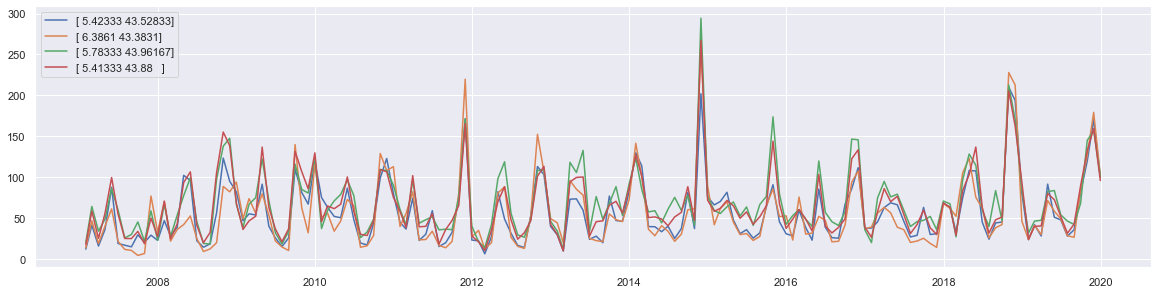

In [3]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
qj=pd.DataFrame(data=datahub, index=DD)
qm=qj.resample('M').sum()
plt.plot(qm)
plt.legend([str(i) for i in stat])
#print qm

## Extraction des pluies journalières et mensuelles dans des fichiers textes (code ajouté)

In [4]:
header=[]
header.extend([str(stat[i]) for i in range(0, len(stat))])
qj.to_csv(os.path.join(path, "PJ_SM2RAIN.txt"), index=True, header=header, sep=";")
qm.to_csv(os.path.join(path, "PM_SM2RAIN.txt"), index=True, header=header, sep=";")